This notebook uses the Titanic data to try and predict who will survive the Titanic disaster.

This notebook has 2 parts: 
1. **Standard Classification Pipeline** - includes data cleaning, feature scaling and hyper-parameters tuning for best performance.
2. **Misclassification Analysis** - Using Jitter plots and the MAGIC tool. 

Link to dataset: [here](https://www.kaggle.com/datasets/prkukunoor/TitanicDataset)

<hr>

# Part 1: Standard Classification Pipeline

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

## Exploratory Data Analysis

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/שנה א' - סמסטר א'/מדעי נתונים טבלאיים/מחברות לפרוייקט/titanic_data.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Attributes Explaination:**

* PassengerId - unique passenger id.

* Survived - this is the class: 1, if the passenger survived and 0 otherwise.

* Pclass - the class of the ticket (1, 2 or 3).

* Name - passenger name.

* Sex - the gender of the passenger.

* Age - the age of the passenger.

* SibSp - number of siblings (Sib) and spouse (Sp) that were with the passenger onboard.

* Parch - number of parents (Par) and children (ch) that were with the passenger onboard.

* Ticket - ticket number.

* Fare - the price of the ticket.

* Cabin -  the number of the passenger's cabin in the ship.

* Embarked - the port in which the passenger boarded the ship.



In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Data Cleaning

Remove irrelevant attributes for classification: PassengerId, Name, Ticket and Cabin - each has a unique value for each passenger.

In [ ]:
df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1, inplace=True)

Fill missing values for "Age" with the mean value:

In [ ]:
df['Age'].fillna(df['Age'].mean(),inplace=True)

Fill 2 missing values for "Embarked" with the mode value:

In [ ]:
df.fillna(df.mode().iloc[0], inplace = True)

Verify that no missing values are left unhandled using the *info* method:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


## Feature Engineering

Replace categorial attributes *sex* and *embarked* with one-hot encoded values.

In [ ]:
df['Sex']=df['Sex'].replace({'male':0, 'female':1})

In [ ]:
one_hot_encoded_embarked = pd.get_dummies(df['Embarked'],drop_first=False)
one_hot_encoded_embarked.head()

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [ ]:
df = pd.concat([df,one_hot_encoded_embarked],axis=1).drop('Embarked',axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,1


## Data Correlation

Examing correlations in the data, and in particular - which attributes correlate with the target class the most.

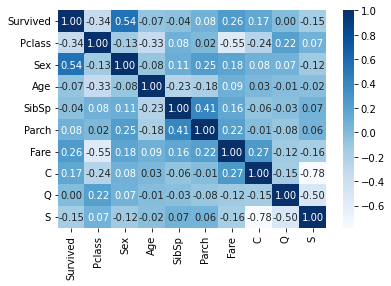

In [ ]:
corr = df.corr()
sns.heatmap(corr,annot=True,cmap='Blues',fmt='.2f');

In [ ]:
df.corr()[['Survived']].sort_values(by ='Survived', ascending=False)

,Survived
Survived,1.000000
Sex,0.543351
Fare,0.257307
C,0.168240
Parch,0.081629
Q,0.003650
SibSp,-0.035322
Age,-0.069809
S,-0.149683
Pclass,-0.338481


***Initial Insights:***

Women (gender = 1) and rich people (who bought the expensive tickets  and therefore have high *Fair* value) tended to survive more. 

I guess it is since they were the first to be put on the lifeboats.

## Prepare Train and Test Data

In [ ]:
X = df.drop(['Survived'],axis=1)
y = df['Survived']
print("All data size: ", X.shape, y.shape)
X_train11, X_test11, y_train, y_test=train_test_split(X,y,test_size=0.20, random_state=41)
print("train size:", X_train11.shape, y_train.shape)
print("test size:" , X_test11.shape, y_test.shape)


All data size:  (891, 9) (891,)
train size: (712, 9) (712,)
test size: (179, 9) (179,)


In [ ]:
scaler = StandardScaler() # After checking MinMaxScaler, RobustScaler and Normalizer scalers - the StandardScaler yielded the best results

# fit and transfrom while keeping the original indeces and columns, see: https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num

X_train = pd.DataFrame(scaler.fit_transform(X_train11), index=X_train11.index, columns=X_train11.columns)
X_test = pd.DataFrame(scaler.transform(X_test11), index=X_test11.index, columns=X_test11.columns)

X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pclass,712.0,1.671572e-16,1.000703,-1.566348,-0.374852,0.816643,0.816643,0.816643
Sex,712.0,2.494883e-18,1.000703,-0.742427,-0.742427,-0.742427,1.346933,1.346933
Age,712.0,2.145600e-16,1.000703,-2.207973,-0.579894,0.000957,0.476320,3.343187
SibSp,712.0,1.496930e-17,1.000703,-0.474848,-0.474848,-0.474848,0.389837,6.442630
Parch,712.0,1.247442e-17,1.000703,-0.474065,-0.474065,-0.474065,-0.474065,6.682136
Fare,712.0,6.860929e-18,1.000703,-0.693702,-0.518903,-0.373160,-0.005897,10.648331
C,712.0,-5.363999e-17,1.000703,-0.479277,-0.479277,-0.479277,-0.479277,2.086476
Q,712.0,1.496930e-17,1.000703,-0.314270,-0.314270,-0.314270,-0.314270,3.181981
S,712.0,7.235161e-17,1.000703,-1.616853,-1.616853,0.618485,0.618485,0.618485


## Classify Using SVM

Best parameters search:

In [ ]:
parameters = {
              'C':[0.1, 1, 10],               
              'gamma':['scale', 'auto'],
              'kernel':('linear', 'poly','rbf', 'sigmoid')              
             }
svm11 = GridSearchCV(SVC(), parameters, cv=5)
svm11.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')})

In [ ]:
svm = SVC(kernel = svm11.best_params_['kernel'],
           C = svm11.best_params_['C'],
           gamma = svm11.best_params_['gamma'])
svm.fit(X_train, y_train)         
svm.score(X_test, y_test) 

0.8547486033519553

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


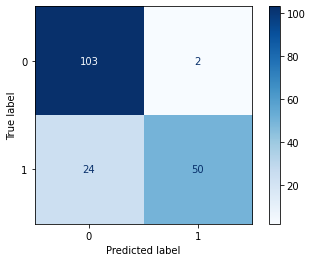

In [ ]:
plot_confusion_matrix(svm, X_test, y_test,values_format="d",cmap='Blues');

In [ ]:
pred1=svm.predict(X_test)
print(classification_report(y_test,pred1,digits=4))

              precision    recall  f1-score   support

           0     0.8110    0.9810    0.8879       105
           1     0.9615    0.6757    0.7937        74

    accuracy                         0.8547       179
   macro avg     0.8863    0.8283    0.8408       179
weighted avg     0.8732    0.8547    0.8490       179



# Part 2: Misclassification Analysis

This section analyses the misclassifications.
In particular, it focuses on the 24 cases of False Negative: 24 survivals (classified 1) got the predicted value of 0.

In [ ]:
expected_label = 1
predicted_label = 0

In [ ]:
def get_index_for_misclassified_samples(clf, X_test, y_test, expected_label, predicted_label):
  pred=clf.predict(X_test)
  misclassified_index = [i for i in range(len(y_test)) if y_test.iloc[i] == expected_label and pred[i] == predicted_label]
  misclassified_samples_index = y_test.iloc[misclassified_index].reset_index()['index']
  return misclassified_samples_index

In [ ]:
misclassified_samples_index = get_index_for_misclassified_samples(svm, X_test, y_test, expected_label, predicted_label)
print(f'There is a total of {len(misclassified_samples_index)} misclassified samples.')
print('The misclssified samples are:')
X.loc[misclassified_samples_index]

There is a total of 24 misclassified samples.
The misclssified samples are:


,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
797,3,1,31.000000,0,0,8.6833,0,0,1
187,1,0,45.000000,0,0,26.5500,0,0,1
248,1,0,37.000000,1,1,52.5542,0,0,1
347,3,1,29.699118,1,0,16.1000,0,0,1
489,3,0,9.000000,1,1,15.9000,0,0,1
839,1,0,29.699118,0,0,29.7000,1,0,0
622,3,0,20.000000,1,1,15.7417,1,0,0
85,3,1,33.000000,3,0,15.8500,0,0,1
484,1,0,25.000000,1,0,91.0792,1,0,0
315,3,1,26.000000,0,0,7.8542,0,0,1


Before moving forwars, validating the misclsasification calculations:

In [ ]:
assert sum(svm.predict(X_test.loc[misclassified_samples_index])) == 0
assert sum(y_test.loc[misclassified_samples_index]) == 24

## Part 2.a Misclassification Analysis With Jitter Plot

In this section I use Jitter plot.

I chose to use Jitter instead of Scatter plot to avoid [overplotting](https://www.displayr.com/what-is-overplotting/), as a lot of the samples have the exact same attributes.



In [ ]:
df1 = df.copy(deep = True)
df1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,1


In [ ]:
df1['Survived'].replace({0:'no', 1:'yes'},inplace = True)

In [ ]:
df1.loc[misclassified_samples_index, 'Survived'] = 'misclassified'

In [ ]:
class_index = 0
attributes = list(df.columns[:class_index]) + list(df.columns[class_index + 1:])
attributes

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'C', 'Q', 'S']

In [ ]:
class_label = df.columns[class_index]
class_label

'Survived'

In [ ]:
color_dict = dict({'no':'#ff8093',
                  'yes':'#9ca5ff',
                  'misclassified': 'black'})

In [ ]:
combinations_count = int(len(attributes) * (len(attributes) - 1) / 2)

In [ ]:
df1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,no,3,0,22.0,1,0,7.2500,0,0,1
1,yes,1,1,38.0,1,0,71.2833,1,0,0
2,yes,3,1,26.0,0,0,7.9250,0,0,1
3,yes,1,1,35.0,1,0,53.1000,0,0,1
4,no,3,0,35.0,0,0,8.0500,0,0,1


The following illustrate the misclassifications (colored with black) against the training-data:

In [ ]:
import math

x_ax_count = math.ceil(combinations_count / 3)
y_ax_count = 3

In [ ]:
selected_data = pd.concat([df1.loc[misclassified_samples_index], df1.loc[X_train.index]])

In [ ]:
assert len(selected_data) == len(X_train) + len(misclassified_samples_index)

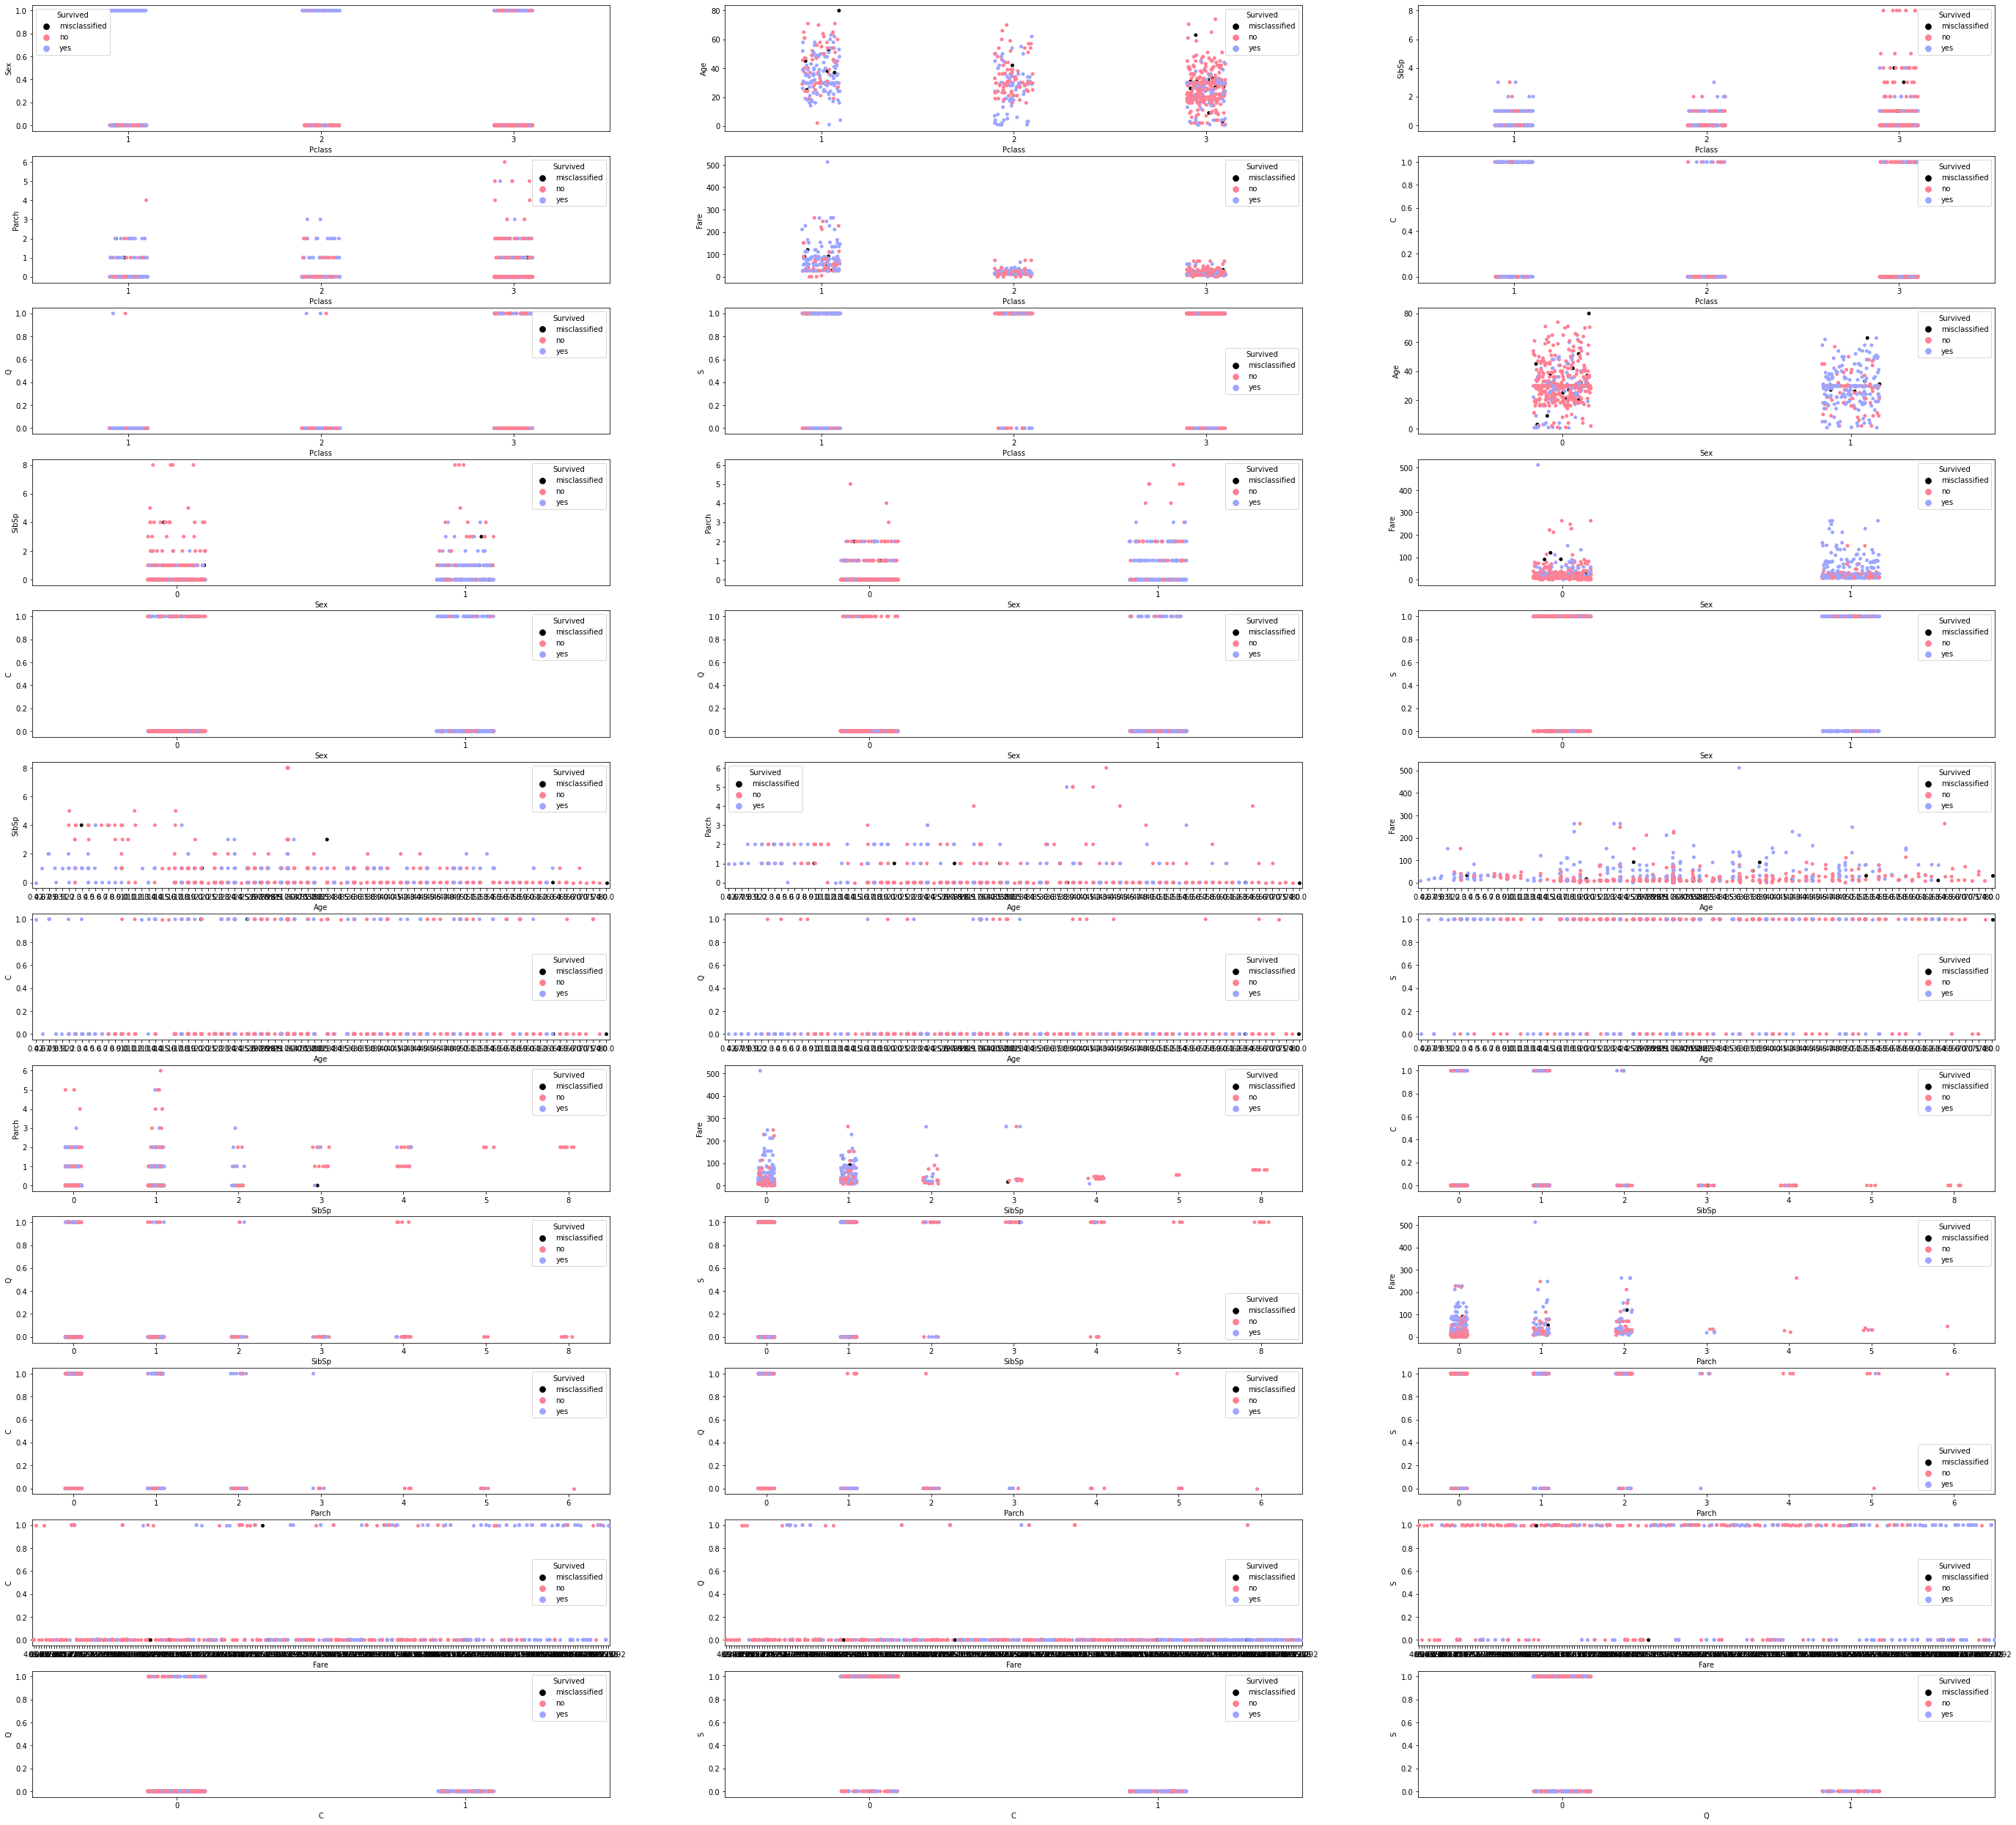

In [ ]:
fig, axs = plt.subplots(x_ax_count,y_ax_count)
fig.set_size_inches(x_ax_count * 4,y_ax_count * 15 )

ax_index = 0

for i in range(len(attributes)):
  for j in range(i + 1, len(attributes)):
      sns.stripplot(x=attributes[i],y=attributes[j],hue=class_label,data=selected_data, ax = axs[int(ax_index / y_ax_count)][ax_index % y_ax_count], palette = color_dict)
      ax_index +=1

For simplicity, I will create Jitter plots only for the 3 highest correlated attributes with the target label - Sex, Fare and C. 

In [ ]:
selected_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
797,misclassified,3,1,31.000000,0,0,8.6833,0,0,1
187,misclassified,1,0,45.000000,0,0,26.5500,0,0,1
248,misclassified,1,0,37.000000,1,1,52.5542,0,0,1
347,misclassified,3,1,29.699118,1,0,16.1000,0,0,1
489,misclassified,3,0,9.000000,1,1,15.9000,0,0,1


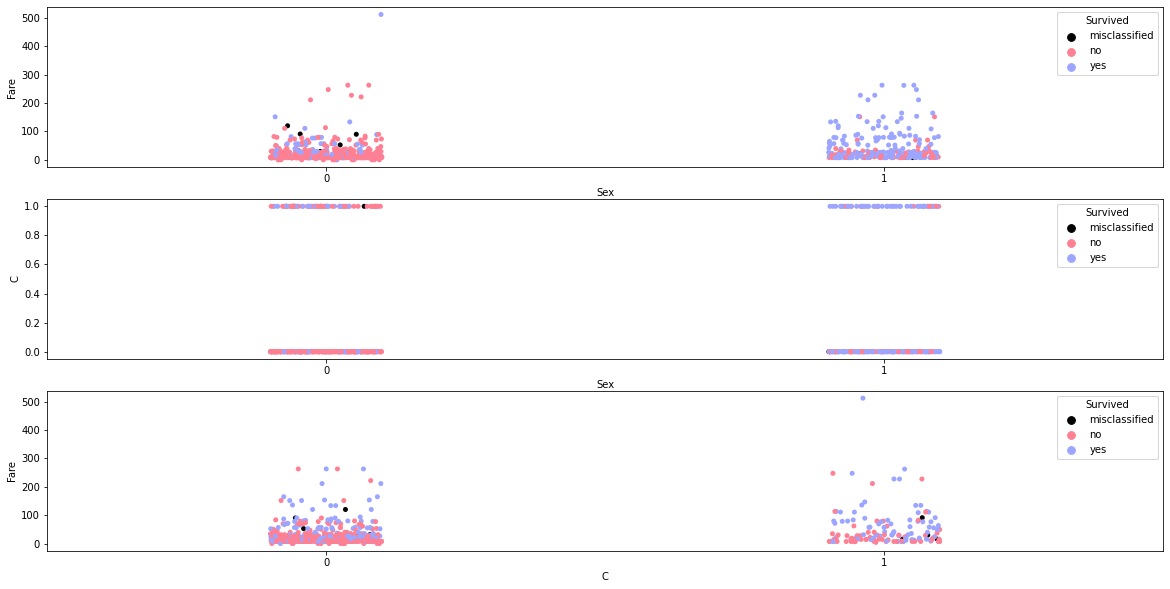

In [ ]:
fig, axs = plt.subplots(3,1)
fig.set_size_inches(20,10)
sns.stripplot(x='Sex',y='Fare',hue=class_label,data=selected_data, ax = axs[0], palette = color_dict)
sns.stripplot(x='Sex',y='C',hue=class_label,data=selected_data, ax = axs[1], palette = color_dict)
sns.stripplot(x='C',y='Fare',hue=class_label,data=selected_data, ax = axs[2], palette = color_dict)

## 2.b Misclassification Anlysis With The MAGIC Tool

In [ ]:
#@title Press the run button to load the MAGIC tool

import numpy as np
import graphviz
import matplotlib.colors as mc
import re
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from PIL import Image

PRESENT_ALL = 'all'
PRESENT_VISITED = 'visited'
PRESENT_MISCLASSIFIED = 'misclassified'

##################
## Graphvitz utils

replace_words = ['<thead>', '<tbody>', '</thead>', '</tbody>', '\n', '\rn', '<table border="1" class="dataframe">',
                 '</table>']
pattern = '|'.join(replace_words)

def dataframe_to_graphviz_table(df):
    '''
    Translates a html table to graphviz format
    references:
    https://renenyffenegger.ch/notes/tools/Graphviz/attributes/label/HTML-like/index
    https://graphviz.org/Gallery/gradient/table.html
    '''
    html_table = df.to_html()
    return re.sub(pattern, '', html_table).replace('th', 'td').replace('<td>', '<td border="1" bgcolor = "white">')

def to_graphviz_format(node_header, cm):
    cm_table = dataframe_to_graphviz_table(cm)
    return '<<table border = "0">' \
           '<tr><td border = "0" colspan="3"><b>%s</b></td></tr>' \
            '%s' \
           '</table>>' % (node_header, cm_table)

####################
def create_legend (expected_label, predicted_label, expected_label_color, predicted_label_color):
    elc = color_to_hex(expected_label_color)
    plc = color_to_hex(predicted_label_color)
    return f'<<table border = "0">' \
           f'<tr><td border = "1" bgcolor= "{elc}"> expected label </td> \
                <td border = "1" bgcolor= "{plc}"> predicted label </td></tr>' \
           f'<tr><td border = "1" bgcolor= "{elc}"> {expected_label} </td> \
                <td border = "1" bgcolor= "{plc}"> {predicted_label} </td></tr>' \
           f'</table>>'

def create_cm_for_node(tp, fp, tn, fn, true_label, false_label):
    if tp == 0 and fp == 0 and tn == 0 and fn == 0:
        return None
    else:
        return pd.DataFrame({false_label: [tn, fn], true_label: [fp, tp]}, index = [false_label,true_label])

def get_nodes_visits_count_list(n_nodes, node_indicator, samples_ids):
    visits_count = [0] * n_nodes
    for sample_id in samples_ids:
        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_indexes = node_indicator.indices[
                     node_indicator.indptr[sample_id]: node_indicator.indptr[sample_id + 1]
                     ]
        for node_index in node_indexes:
            visits_count[node_index] += 1
    return visits_count

def color_to_hex(color):
    try:
        color = mc.cnames[color]
    except:
        pass
    return color

def merge_color(first_color, first_color_quantity, second_color, second_color_quantity):
    if first_color_quantity == 0 and second_color_quantity == 0:
        return 'white'
    else:
        fc = color_to_hex(first_color)
        sc = color_to_hex(second_color)
        fc_rgb = tuple(int(fc.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        sc_rgb = tuple(int(sc.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        total = first_color_quantity + second_color_quantity
        adjusted_r = round((first_color_quantity * fc_rgb[0] + second_color_quantity * sc_rgb[0]) / total)
        adjusted_g = round((first_color_quantity * fc_rgb[1] + second_color_quantity * sc_rgb[1]) / total)
        adjusted_b = round((first_color_quantity * fc_rgb[2] + second_color_quantity * sc_rgb[2]) / total)
        return '#%02x%02x%02x' % (adjusted_r, adjusted_g, adjusted_b)

def plot_misclassification_in_tree(clf, X, y, expected_label, predicted_label, expected_label_color, predicted_label_color,
                                   show_cm = True, present = PRESENT_ALL):
    y = np.array(y)  # Will be easier if y is guaranteed to be of type np array
    v = graphviz.Digraph()

    v.node(str(-1), create_legend(expected_label, predicted_label, expected_label_color, predicted_label_color),
           {'shape': 'component', 'style': 'filled', 'fillcolor': 'white'})

    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    classification = clf.predict(X)
    node_indicator = clf.decision_path(X)

    # Step 1: check how the true data traverse along the classifier
    expected_label_labeled_samples_ids = [i for i in range(len(X)) if y[i] == expected_label]
    predicted_label_labeled_samples_ids = [i for i in range(len(X)) if y[i] == predicted_label]

    expected_label_labeled_visit_count = get_nodes_visits_count_list(n_nodes, node_indicator, expected_label_labeled_samples_ids)
    predicted_label_labeled_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, predicted_label_labeled_samples_ids)

    # Step 2: inspect how the classifier would classify the samples - and create a confusion marix for it.
    true_positive_samples_ids = [i for i in range(len(X)) if
                                 y[i] == expected_label and classification[i] == expected_label]
    false_positive_samples_ids = [i for i in range(len(X)) if
                                  y[i] == predicted_label and classification[i] == expected_label]
    true_negative_samples_ids = [i for i in range(len(X)) if
                                 y[i] == predicted_label and classification[i] == predicted_label]
    false_negative_samples_ids = [i for i in range(len(X)) if
                                  y[i] == expected_label and classification[i] == predicted_label]

    tp_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, true_positive_samples_ids)
    fp_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, false_positive_samples_ids)
    tn_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, true_negative_samples_ids)
    fn_visits_count = get_nodes_visits_count_list(n_nodes, node_indicator, false_negative_samples_ids)

    if PRESENT_ALL == present:
        nodes_ids_to_plot = range(n_nodes)
    elif PRESENT_VISITED == present:
        total_visits_count = [sum(x) for x in zip(tp_visits_count, fp_visits_count, tn_visits_count, fn_visits_count)]
        nodes_ids_to_plot = [i for i in range(len(total_visits_count)) if total_visits_count[i] > 0]
    elif PRESENT_MISCLASSIFIED == present:
        nodes_ids_to_plot = [i for i in range(len(fn_visits_count)) if fn_visits_count[i] > 0]
    else:
        raise Exception('Uknown present value: %s' % present)

    for i in nodes_ids_to_plot:
        node_id = str(i)

        if children_left[i] == children_right[i]: # this is a leaf
            label = str(clf.classes_[np.argmax(clf.tree_.value[i])])
            if show_cm:
                cm = create_cm_for_node(tp_visits_count[i], fp_visits_count[i], tn_visits_count[i], fn_visits_count[i], expected_label, predicted_label)
                if cm is None:
                    node_content = label
                else:
                    node_content = to_graphviz_format(label, cm)
            else:
                node_content = label
            peripheries = '2' if fn_visits_count[i] > 0 else '1'
            fill_color = merge_color(expected_label_color, expected_label_labeled_visit_count[i], predicted_label_color, predicted_label_labeled_visits_count[i])
            v.node(node_id, node_content, {'shape': 'rect', 'style': 'filled', 'fillcolor': fill_color, 'peripheries': peripheries})

        else: # this is a split node
            node_feature = X.columns[feature[i]]
            node_tresshold = threshold[i]

            label = str(node_feature)
            if show_cm:
                cm = create_cm_for_node(tp_visits_count[i], fp_visits_count[i], tn_visits_count[i], fn_visits_count[i], expected_label, predicted_label)
                if cm is None:
                    node_content = label
                else:
                    node_content = to_graphviz_format(label, cm)
            else:
                node_content = label

            fill_color = merge_color(expected_label_color, expected_label_labeled_visit_count[i], predicted_label_color, predicted_label_labeled_visits_count[i])
            peripheries = '2' if fn_visits_count[i] > 0 else '1'
            v.node(node_id, node_content, {'shape': 'rect', 'style': 'filled', 'fillcolor': fill_color, 'peripheries': peripheries})

            if children_left[i] in nodes_ids_to_plot:
                v.edge(node_id, str(children_left[i]), node_feature + "<=" + str(round(node_tresshold, 5)))
            if children_right[i] in nodes_ids_to_plot:
                v.edge(node_id, str(children_right[i]), node_feature + ">" + str(round(node_tresshold, 5)))

    v.node(str(n_nodes), f'Total misclassification: {len(false_negative_samples_ids)}/{len(X)}',  {'shape': 'underline'}) # TODO replace with existing conut
    # v.render(directory='doctest-output', view=True, format='jpeg')
    output_path = v.render(format = 'jpg')
    im = Image.open(output_path) 
      
    # resize the image for better presentation 
    width, height = int(im.width / im.height * 1000), 1000
    im_resized = im.resize((width, height))
    return clf, im_resized

def plot_misclassification(X_train, y_train, X_test, y_test, expected_label, predicted_label, expected_label_color, predicted_label_color,
                           show_cm = True, present = PRESENT_ALL, max_depth = None):
    # Note: setting random_state to a constant number for deterministic tree creation. See: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    clf = DecisionTreeClassifier(random_state=42) if max_depth is None else  DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    return plot_misclassification_in_tree(clf, X_test, y_test, expected_label, predicted_label, expected_label_color, predicted_label_color, show_cm, present)


def extract_decision_predicate_by_path(clf, X):
    X_test = X.to_numpy()

    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    node_indicator = clf.decision_path(X_test)
    leaf_id = clf.apply(X_test)
    samples_rules_dict = {}

    for sample_id in range(len(X)):
        rules = []
        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_index = node_indicator.indices[
                     node_indicator.indptr[sample_id]: node_indicator.indptr[sample_id + 1]
                     ]

        for node_id in node_index:
            # continue to the next node if it is a leaf node
            if leaf_id[sample_id] == node_id:
                continue

            # check if value of the split feature for sample 0 is below threshold
            if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
                threshold_sign = "<="
            else:
                threshold_sign = ">"

            rules.append(f'(x[\'{X.columns[feature[node_id]]}\'] {threshold_sign} {threshold[node_id]})')

        samples_rules_dict[X.index[sample_id]] = " & ".join(rules)
    return samples_rules_dict


When splitting the plain using 5 splits (to 5 subplains), we can see that in most cases, test-samples labels as 0 are the majority where samples with label 1 are misclassified.

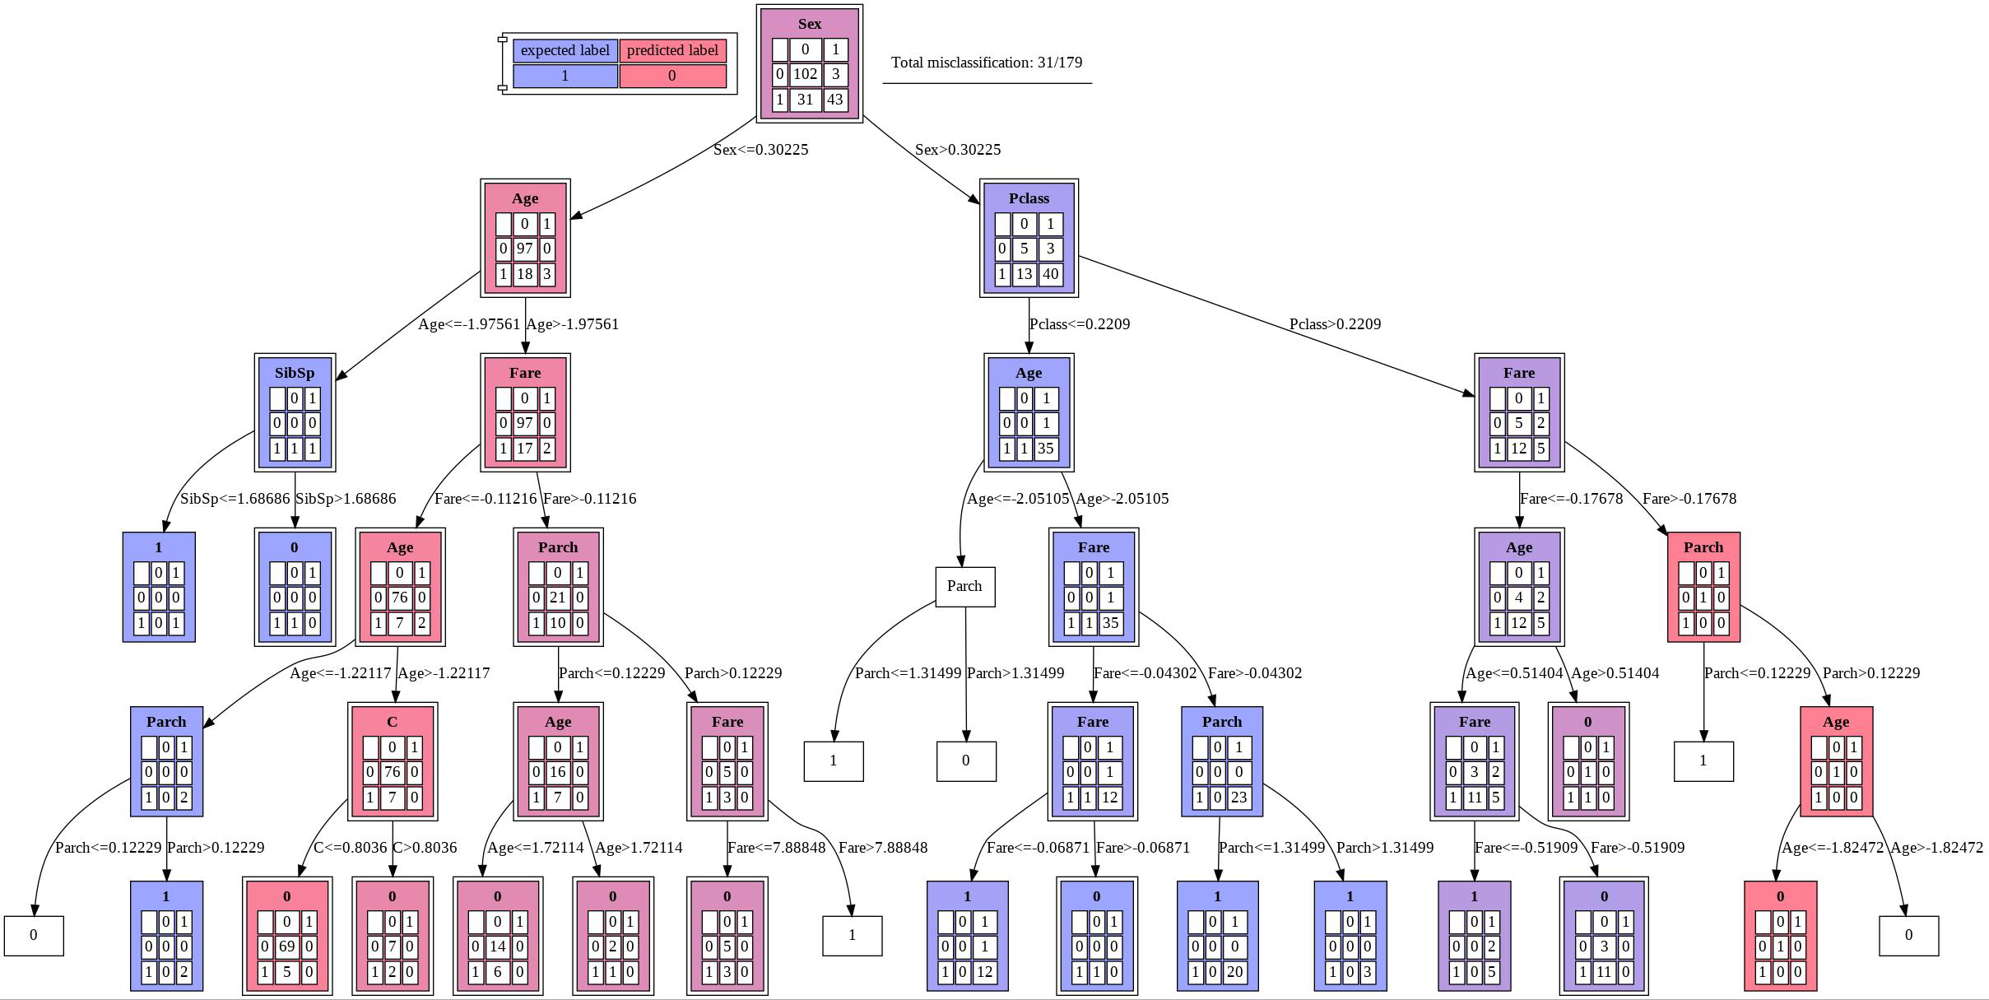

In [ ]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label, predicted_label, '#9ca5ff', '#ff8093',
                           show_cm = True, present = 'all', max_depth = 5)
plot

If we will not limit the plain's splits count (i.e. won't limit the tree's depth), the phenomenon reproduces.

We still have 21 misclassifications... but why?

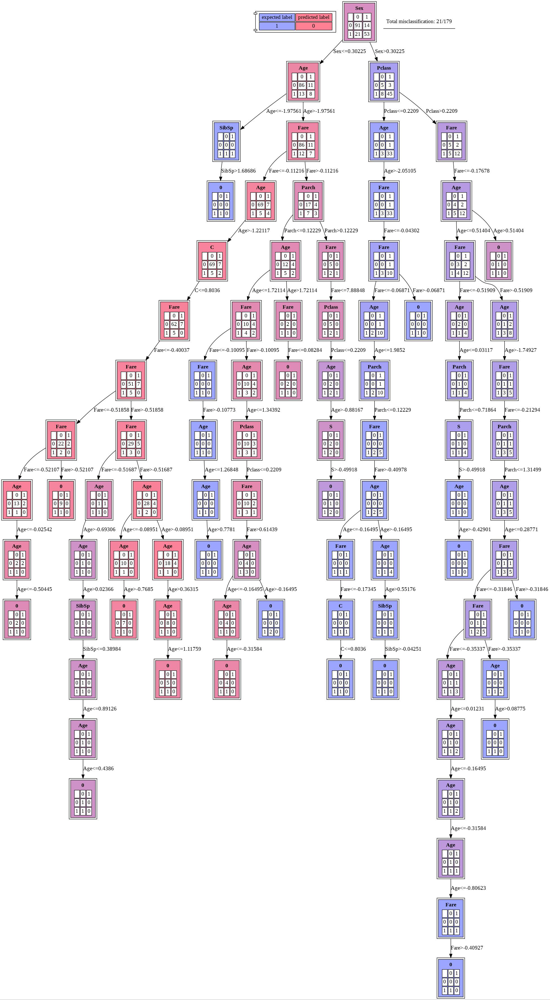

In [ ]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label, predicted_label, '#9ca5ff', '#ff8093',
                           show_cm = True, present = 'misclassified')
plot

It seems that there are 21 samples in the test-set that reach the same subplains where the majority were 0-labeled samples from the train-set. 

To prove it, I'll use the extract_decision_predicate_by_path method that gets a decision-tree clf and test-set X and returns the predicate representing the path in the tree for each sample of X. This predicate represents the relevant subplain.

In [ ]:
classification = clf.predict(X_test)
misclassified_samples_indices = [i for i in range(len(classification)) if classification[i] == predicted_label and y_test.iloc[i] == expected_label]

misclassification_to_predicates = extract_decision_predicate_by_path(clf, X_test.iloc[misclassified_samples_indices])
misclassification_stat_lst = []

history = set([])
representing_samples = []

for i in misclassification_to_predicates:
    if misclassification_to_predicates[i] in history: # avoid repeating the analysis for samples with same predicate
        continue
    else:
        history.add(misclassification_to_predicates[i])
        representing_samples.append(i)

    predicate = eval('lambda x: ' + misclassification_to_predicates[i])

    train_samples = X_train[predicate(X_train)]
    train_samples_classification = y_train[train_samples.index]
    train_classified_as_prediced = sum(train_samples_classification == predicted_label)
    train_classified_as_expcetd = sum(train_samples_classification == expected_label)

    test_samples = X_test[predicate(X_test)]
    test_samples_classification = y_test[test_samples.index]
    test_classified_as_prediced = sum(test_samples_classification == predicted_label)
    test_classified_as_expcetd = sum(test_samples_classification == expected_label)

    misclassification_stat_lst.append([train_classified_as_prediced, train_classified_as_expcetd, test_classified_as_prediced, test_classified_as_expcetd, misclassification_to_predicates[i]])

investigation_results = pd.DataFrame(data = misclassification_stat_lst, index = representing_samples, columns = ['train(predicted)', 'train(excpected)', 'test(prediced)', 'test(expcetd)', 'predicate'])
print(investigation_results.iloc[:,:-1])
print("total misclassification: %d" % sum(investigation_results['test(expcetd)']))


     train(predicted)  train(excpected)  test(prediced)  test(expcetd)
187                 1                 0               0              1
248                10                 0               1              2
830                 4                 0               0              1
85                  1                 0               0              1
484                 3                 0               4              1
315                 2                 0               0              1
391                20                 0               2              1
323                 1                 0               0              1
328                 4                 0               0              1
261                 5                 0               0              1
224                10                 0               0              2
821                30                 0               7              1
345                 2                 0               0              1
483   

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


As an example, I will inspect the predicate for sample 248.

In [ ]:
investigation_results.loc[248].predicate

"(x['Sex'] <= 0.30225297808647156) & (x['Age'] > -1.9756059050559998) & (x['Fare'] > -0.1121598593890667) & (x['Parch'] > 0.12228526175022125) & (x['Fare'] <= 7.888484716415405) & (x['Pclass'] <= 0.2208952009677887) & (x['Age'] > -0.881669819355011) & (x['S'] > -0.499183714389801)"

Here are the samples from the train-set that match this predicate:

In [ ]:
func = eval('lambda x: ' + investigation_results.loc[248].predicate)

train_sample_indeces = X_train[func(X_train)].index

train_samples = df.loc[train_sample_indeces]
print("Total samples from train-set:",len(train_samples))
print("Samples:")
train_samples


Total samples from train-set: 10
Samples:


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
745,0,1,0,70.0,1,1,71.0000,0,0,1
438,0,1,0,64.0,1,4,263.0000,0,0,1
262,0,1,0,52.0,1,1,79.6500,0,0,1
124,0,1,0,54.0,0,1,77.2875,0,0,1
27,0,1,0,19.0,3,2,263.0000,0,0,1
684,0,2,0,60.0,1,1,39.0000,0,0,1
450,0,2,0,36.0,1,2,27.7500,0,0,1
848,0,2,0,28.0,0,1,33.0000,0,0,1
102,0,1,0,21.0,0,1,77.2875,0,0,1
145,0,2,0,19.0,1,1,36.7500,0,0,1


In the test set, on the other hand, there's only 3 samples that answers this predicate:

In [ ]:
test_sample_indeces = X_test[func(X_test)].index

test_samples = df.loc[test_sample_indeces]
print("Total samples from train-set:",len(test_samples))
print("Samples:")
test_samples


Total samples from train-set: 3
Samples:


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
248,1,1,0,37.0,1,1,52.5542,0,0,1
332,0,1,0,38.0,0,1,153.4625,0,0,1
390,1,1,0,36.0,1,2,120.0000,0,0,1


So, all in all, out of 13 samples labeles with 0, two are labeled with 1 - and it seems that the classifier made the reasonable choise of labeling them as 0 as well, although it creates a False Negative situation.

# Concolusion

In this notebook we inspected misclassification that arosed from similar samples that had the same charactersitics: As in the train-set there were more samples labeled as 1 (survived) while in the test-set there were more samples labeled as 0 (died) with the same characteristics, the classifier also classified them as 0 and rightly so.

The MAGIC tool is more useful here.
The reason is that most of the data is categorial, so:
* Jitter and Scatter plots suffer from overplotting. It flaws the explainability of the plot.
* There are numeral samples that have almost-identical characteristics - and that is better depicted in a tree than in a plot.


<hr>

# Appendix: Illustrations For The Questionnaire

In the questionnaire, for the MAGIC tool I used a tree of depth 4, as it is simpler than the detailed one presented in this notebook. Note that it doesn't add any additional information or conclusions besides those that were discussed above.

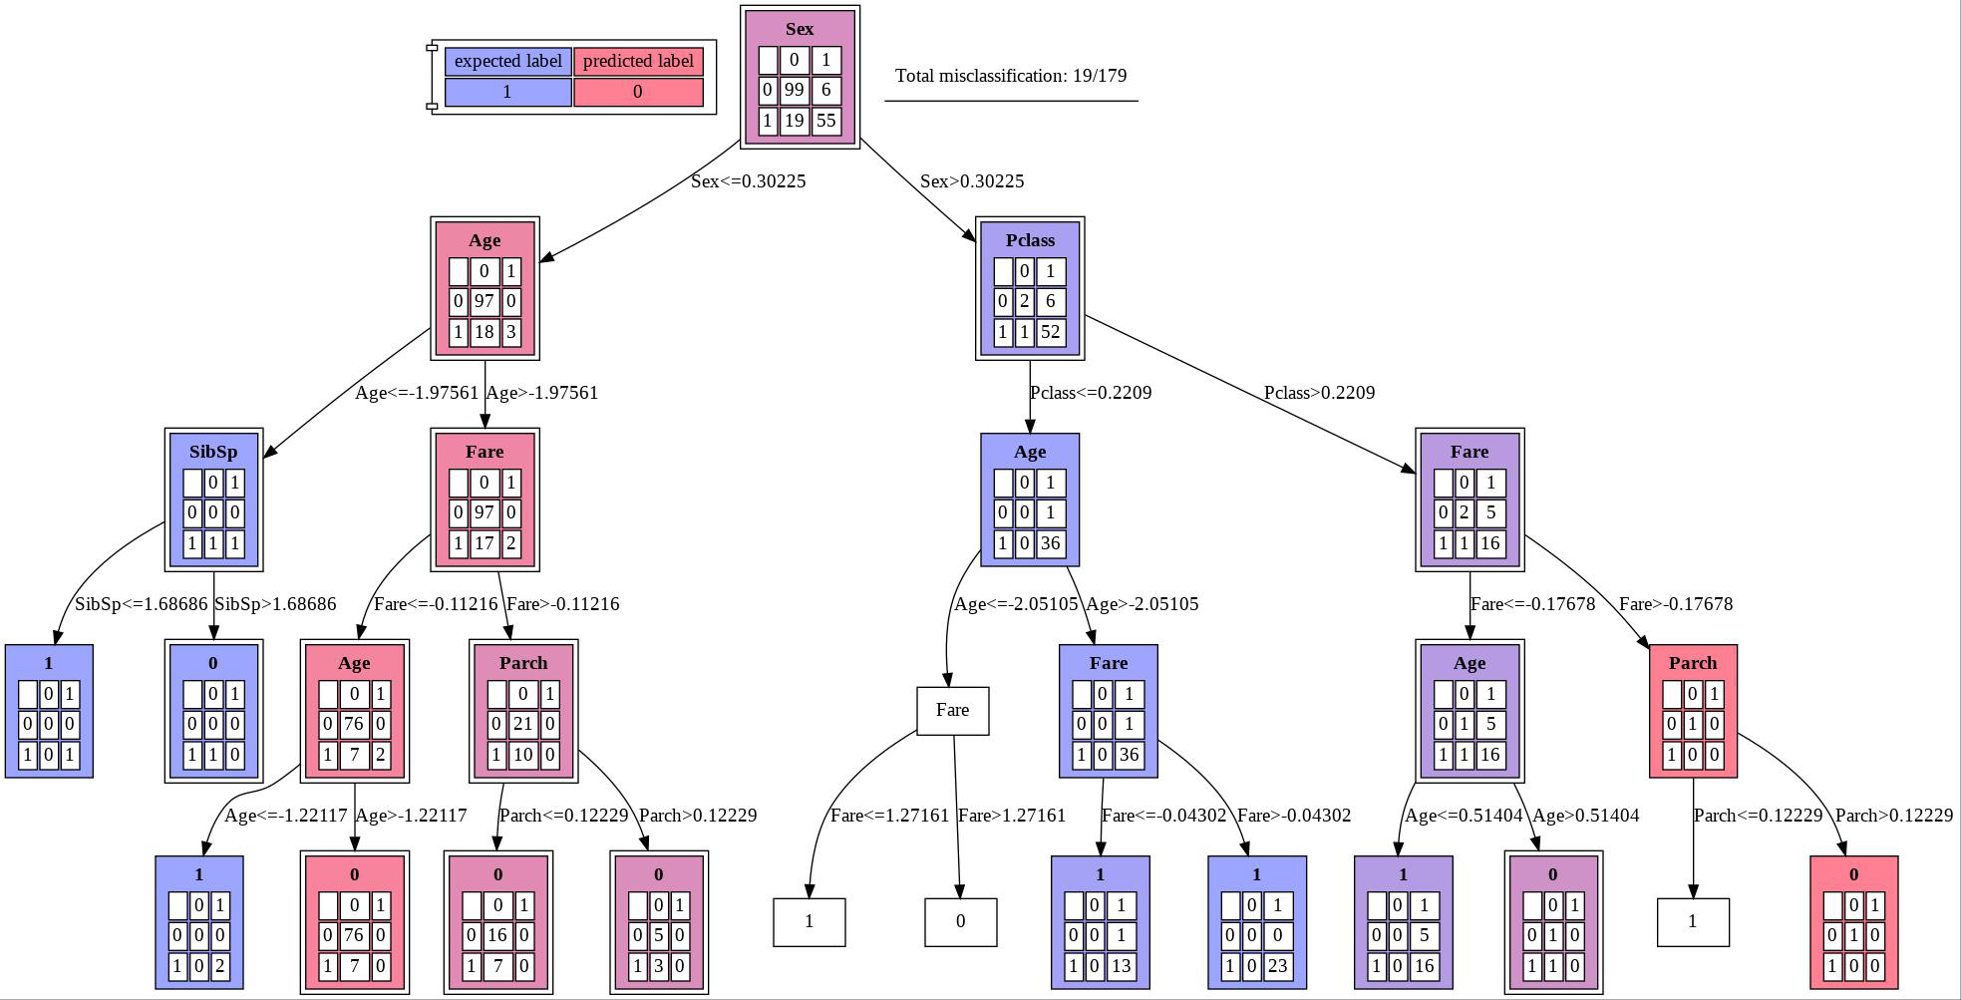

In [ ]:
clf, plot = plot_misclassification(X_train, y_train, X_test, y_test, expected_label, predicted_label, '#9ca5ff', '#ff8093',
                           show_cm = True, present = 'all', max_depth = 4)
plot

For the Jitter plot, I plotted the 3 most-corralted attributes with the target-class and made sure that the misclassified samples are plotted *ontop* of the other samples so they can be more easily spotted:

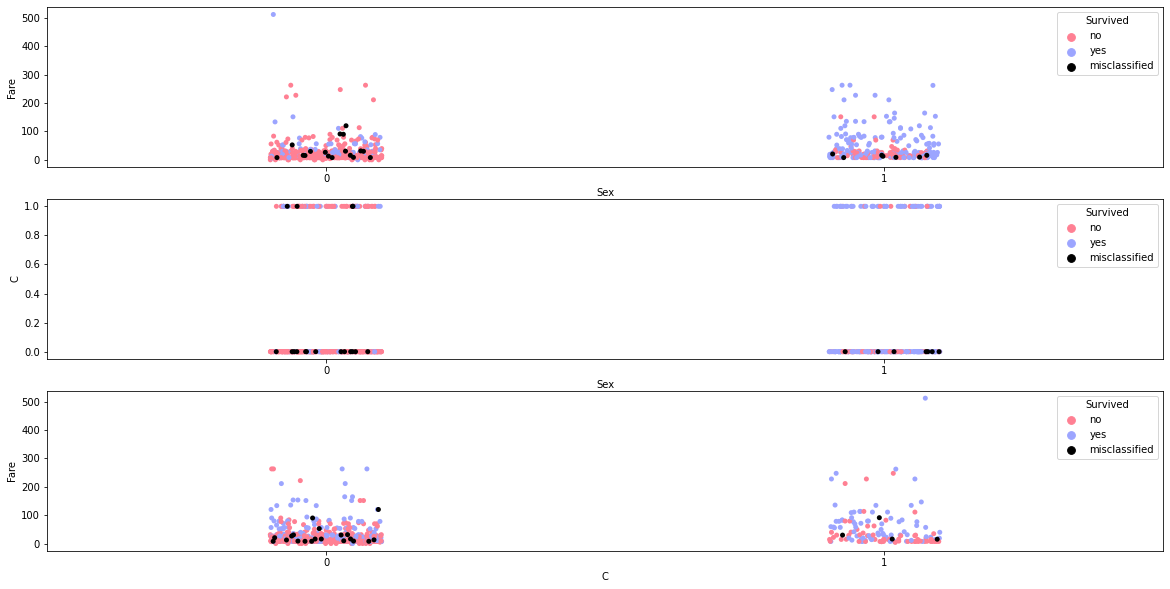

In [ ]:
fig, axs = plt.subplots(3,1)
fig.set_size_inches(20,10)

sns.stripplot(x='Sex',y='Fare',hue=class_label,data=df1.loc[X_train.index], ax = axs[0], palette = color_dict)
sns.stripplot(x='Sex',y='Fare',hue=class_label,data=df1.loc[misclassified_samples_index], ax = axs[0], palette = color_dict)

sns.stripplot(x='Sex',y='C',hue=class_label,data=df1.loc[X_train.index], ax = axs[1], palette = color_dict)
sns.stripplot(x='Sex',y='C',hue=class_label,data=df1.loc[misclassified_samples_index], ax = axs[1], palette = color_dict)

sns.stripplot(x='C',y='Fare',hue=class_label,data=df1.loc[X_train.index], ax = axs[2], palette = color_dict)
sns.stripplot(x='C',y='Fare',hue=class_label,data=df1.loc[misclassified_samples_index], ax = axs[2], palette = color_dict)